<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
!python --version

Python 3.10.9


In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

# Block Building

In [3]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [4]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [5]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0761 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [6]:
from pyjedai.block_cleaning import BlockFiltering

In [7]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [8]:
from pyjedai.block_cleaning import BlockPurging

In [9]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/4952 [00:00<?, ?it/s]

In [10]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3924.0
Runtime: 0.0242 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.85% 
	Recall:        99.44%
	F1-score:       1.68%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1070
	False positives: 125406
	True negatives: 1032364
	False negatives: 6
	Total comparisons: 126476
───────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.8460103102564913,
 'Recall %': 99.44237918215613,
 'F1 %': 1.6777471149021574,
 'True Positives': 1070,
 'False Positives': 125406,
 'True Negatives': 1032364,
 'False Negatives': 6}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [12]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM
)

In [45]:
%%time
LTPM = LocalTopPM(
    budget = 3,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = LTPM.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=True)

CPU times: user 2.81 s, sys: 12 ms, total: 2.83 s
Wall time: 2.81 s


In [46]:
print(len(ltpm_pairs_graph.edges))

8960


In [60]:
%%time
GTPM = GlobalTopPM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = GTPM.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=True)

CPU times: user 1.41 s, sys: 11.9 ms, total: 1.42 s
Wall time: 1.41 s


In [61]:
print(len(gtpm_pairs_graph.edges))

10000


In [64]:
%%time
GPSNM = GlobalPSNM(
    budget = 10000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = GPSNM.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=True)

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.29 s


In [67]:
print(len(gpsnm_pairs_graph))

129097


In [65]:
%%time
LPSNM = LocalPSNM(
    budget = 10000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = LPSNM.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=True)

KeyboardInterrupt: 

In [107]:
%%time
ENNBPM = EmbeddingsNNBPM(
    budget = 8,
    vectorizer = 'sminilm',
    similarity_search = 'faiss',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ENNBPM.predict(cleaned_blocks, data, tqdm_disable=True, method='DFS', full_emission=True)

Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cpu
Loading embeddings from file...
Loading file:  .embeddings/sminilm_d1_1.npy
Loading file:  .embeddings/sminilm_d2_2.npy
Loading embeddings from file finished
Saving embeddings...
CPU times: user 266 ms, sys: 254 µs, total: 267 ms
Wall time: 67.2 ms


In [17]:
%%time
rpm = RandomPM(
    budget = 10000,
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 306 ms, sys: 4.35 ms, total: 310 ms
Wall time: 38.8 ms


In [94]:
%%time
pesm = PESM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(cleaned_blocks, data, tqdm_disable=True, method='HB')

CPU times: user 4.96 s, sys: 4.39 ms, total: 4.97 s
Wall time: 4.98 s


In [20]:
def reverse(id1, id2):
    if(id1 > id2):
        return (id2, id1)
    else:
        return (id1, id2)

def get_duplicates(tuple_list):
    count = 0
    seen_pairs = set()
    duplicates = []
    
    for item in tuple_list:
        weight, id1, id2 = item
        pair = reverse(id1, id2)
        
        if pair in seen_pairs:
            dupl.append(pair)
        else:
            seen_pairs.add(pair)
    
    return duplicates

In [62]:
# some progressive methods don't allow for comparison storage within graph
# it changes the order of the emitted pairs
methods_prediction_data = []

# ltpm_pairs_graph.edges = sorted(ltpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
# gtpm_pairs_graph.edges = sorted(gtpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# ltpm_pairs_graph.edges = [edge[:2] for edge in ltpm_pairs_graph.edges]
# gtpm_pairs_graph.edges = [edge[:2] for edge in gtpm_pairs_graph.edges]


# ltpm_pairs_graph
# gtpm_pairs_graph
# rpm_pairs_graph
# gpsnm_pairs_graph
# lpsnm_pairs_graph
# pesm_pairs_graph

# methods_prediction_data.append(("Random", [edge for edge in rpm_pairs_graph.edges]))
# methods_prediction_data.append(("Local Top", [edge[:2] for edge in ltpm_pairs_graph.edges]))
methods_prediction_data.append(("Global Top", [edge[:2] for edge in gtpm_pairs_graph.edges]))
# methods_prediction_data.append(("GSN", gpsnm_pairs_graph))
# methods_prediction_data.append(("LSN", lpsnm_pairs_graph))
# methods_prediction_data.append(("ES", pesm_pairs_graph))
# methods_prediction_data.append(("ENNBPM-TOP", ennbpm_pairs_graph))

TP[483][234]
Not Checked
Total TPs Found: 1
Emission[1]
TP[104][988]
Not Checked
Total TPs Found: 2
Emission[2]
TP[798][1015]
Not Checked
Total TPs Found: 3
Emission[3]
TP[393][972]
Not Checked
Total TPs Found: 4
Emission[4]
TP[643][777]
Not Checked
Total TPs Found: 5
Emission[5]
TP[490][553]
Not Checked
Total TPs Found: 6
Emission[6]
TP[246][997]
Not Checked
Total TPs Found: 7
Emission[7]
TP[397][284]
Not Checked
Total TPs Found: 8
Emission[8]
TP[722][1043]
Not Checked
Total TPs Found: 9
Emission[9]
TP[218][12]
Not Checked
Total TPs Found: 10
Emission[10]
TP[17][830]
Not Checked
Total TPs Found: 11
Emission[11]
TP[614][532]
Not Checked
Total TPs Found: 12
Emission[12]
TP[503][533]
Not Checked
Total TPs Found: 13
Emission[13]
TP[504][593]
Not Checked
Total TPs Found: 14
Emission[14]
TP[113][282]
Not Checked
Total TPs Found: 15
Emission[15]
TP[305][949]
Not Checked
Total TPs Found: 16
Emission[16]
TP[114][1016]
Not Checked
Total TPs Found: 17
Emission[17]
TP[569][442]
Not Checked
Total 

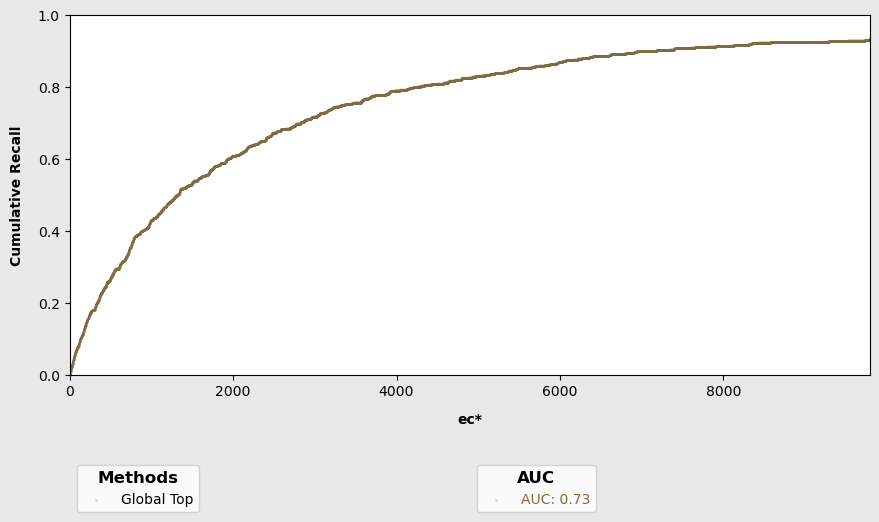

CPU times: user 157 ms, sys: 4.02 ms, total: 161 ms
Wall time: 160 ms


In [63]:
%%time
GTPM.evaluate_auc_roc(methods_prediction_data = methods_prediction_data, proportional = False, true_positives_checked=[GTPM.true_pair_checked])

In [ ]:
919 1275
919 199
919 1709
919 633
919 1607
919 531
919 2098
919 1022
919 2056
919 980
919 1741
919 665
919 1882
919 806


919 199
HA
919 633
HA
919 531
HA
919 1022
HA
919 980
HA
919 665
HA
919 806
HA
284 199

919 199
919 633
919 531
919 1022
919 980
919 665
919 806
284 199
993 199
326 199
557 199
1017 199
825 199
834 287


E(919) C(1275) Em(1) TPF(0)
E(919) C(1709) Em(2) TPF(0)
E(919) C(1607) Em(3) TPF(0)
E(919) C(2098) Em(4) TPF(0)
E(919) C(2056) Em(5) TPF(0)
E(919) C(1741) Em(6) TPF(0)
E(919) C(1882) Em(7) TPF(0)
E(1275) C(284) Em(8) TPF(0)
E(1275) C(993) Em(9) TPF(0)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [ ]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
ccc.evaluate(clusters, with_classification_report=True)

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [ ]:
umc.evaluate(clusters, with_classification_report=True)